# Reading Decisions

This is a notebook experimenting with reading decision datasets.  
The the following dataset can be found at:
[https://zenodo.org/record/3911068#.X60JqS-ZPUo](https://zenodo.org/record/3911068#.X60JqS-ZPUo)

In [1]:
import re
import collections
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

In [2]:
df = pd.read_csv('2020_06_23_CE-BVerwG_DE_Datensatz.csv')
df

,Unnamed: 0,doc_id,text,Gericht,Datum,Entscheidungsart,Senat,Verfahrensart,Ordinalzahl,Eingangsjahr,Suffix
0,1,BVerwG_1997-02-26_U_6_C_3_96_NA.txt,BUNDESVERWALTUNGSGERICHT\nIM NAMEN DES VOLKES\...,BVerwG,1997-02-26,U,6,C,3,96,NaN
1,2,BVerwG_2000-12-14_B_21_WB_107_00_NA.txt,BUNDESVERWALTUNGSGERICHT\nBeschluss\nBVerwG 1 ...,BVerwG,2000-12-14,B,21,WB,107,0,NaN
2,3,BVerwG_2002-01-10_B_9_A_9_02_NA.txt,BUNDESVERWALTUNGSGERICHT\nBESCHLUSS\nBVerwG 9 ...,BVerwG,2002-01-10,B,9,A,9,2,NaN
3,4,BVerwG_2002-01-14_B_4_BN_1_02_NA.txt,BUNDESVERWALTUNGSGERICHT\nBESCHLUSS\nBVerwG 4 ...,BVerwG,2002-01-14,B,4,BN,1,2,NaN
4,5,BVerwG_2002-01-17_B_1_B_12_02_NA.txt,BUNDESVERWALTUNGSGERICHT\nBESCHLUSS\nBVerwG 1 ...,BVerwG,2002-01-17,B,1,B,12,2,NaN
...,...,...,...,...,...,...,...,...,...,...,...
24219,24220,BVerwG_2020-05-07_B_2_B_35_19_NA.txt,BESCHLUSS\nBVerwG 2 B 35.19\nOVG 4 B 33.14\n\n...,BVerwG,2020-05-07,B,2,B,35,19,NaN
24220,24221,BVerwG_2020-05-12_B_4_BN_3_20_NA.txt,BESCHLUSS\nBVerwG 4 BN 3.20\nOVG 2 C 285/18\n\...,BVerwG,2020-05-12,B,4,BN,3,20,NaN
24221,24222,BVerwG_2020-05-13_B_6_PKH_6_19_NA.txt,BESCHLUSS\nBVerwG 6 PKH 6.19\n\nIn der Verwalt...,BVerwG,2020-05-13,B,6,PKH,6,19,NaN
24222,24223,BVerwG_2020-05-18_B_1_B_21_20_NA.txt,"BESCHLUSS\nBVerwG 1 B 21.20, 1 PKH 12.20\nVGH ...",BVerwG,2020-05-18,B,1,B,21,20,NaN


## Accessing decision texts

In [3]:
example_decision_text = df['text'][0]
example_decision_text[:1000]

'BUNDESVERWALTUNGSGERICHT\nIM NAMEN DES VOLKES\nURTEIL\nBVerwG 6 C 3.96\nOVG 10 L 5059/93\n\nVerkündet\nam 26. Februar 1997\nCremer\nJustizhauptsekretär\nals Urkundsbeamter der Geschäftsstelle\n\nIn der Verwaltungsstreitsache\n\n\x0c- 2 -\n\nhat der 6. Senat des Bundesverwaltungsgerichts\nauf die mündliche Verhandlung vom 26. Februar 1997\ndurch die Richter\nDr. S e i b e r t ,\nA l b e r s ,\nDr. V o g e l g e s a n g ,\ndie Richterin\nE c k e r t z - H ö f e r\nund den Richter\nDr.\nS c h m u t z l e r\nfür Recht erkannt:\nDie Revision der Beigeladenen gegen das Urteil\ndes Niedersächsischen Oberverwaltungsgerichts\nvom 19. Dezember 1995 wird mit der Maßgabe zurückgewiesen, daß der Beklagte die erstinstanzlich ausgesprochene Verpflichtung auch in der\nWeise erfüllen kann, daß er der Klägerin neben\nden dort genannten Entscheidungen auch alle anderen als veröffentlichungswürdig ausgewählten\noder als solche anerkannten und mit einer neutralisierten Fassung versehenen Entscheidungen\nd

## Counting occurrences
In this example the occurrences of “VwGO” in all decisions is counted:

In [4]:
search = r'VwGO'

count = 0
for decision in df['text']:
    count += len(re.findall(search, decision))
print('Count (“%s“): ' % search, count)

Count (“VwGO“):  136807


In [6]:
re.findall(r'§.*VwGO', example_decision_text)

['§ 65 Abs. 2 VwGO', '§ 55 VwGO', '§ 154 VwGO']

## Find references

In the following section some functions are defined to find references in text and convert them to a uniform style:

In [7]:
hierarchy = {
    'section': '§ %d ',
    'paragraph': 'Abs. %d ',
    'clause': 'S. %d',
}

def str_int(string: str) -> int:
    if string == '':
        return None
    else:
        return int(string)
    
def reference_to_str(reference_dict: dict) -> str:
    result = ''
    for key, expression in hierarchy.items():
        value = reference_dict[key]
        if value != None:
            result += expression %  value
    result = result.strip()
    return result

def find_references(decision_text: str, book: str) -> list:
    references = re.findall(r'§ (\d+)\W*[Abs.]*\W*(\d+)*\W*[S.]*\W*(\d+)*\W*' + book, decision_text)
    references = [{'section': str_int(m[0]), 'paragraph': str_int(m[1]), 'clause': str_int(m[2])} for m in references]
    return references

In [8]:
references = find_references(example_decision_text, 'VwGO')
references

[{'section': 65, 'paragraph': 2, 'clause': None},
 {'section': 55, 'paragraph': None, 'clause': None},
 {'section': 154, 'paragraph': 2, 'clause': None},
 {'section': 154, 'paragraph': None, 'clause': None}]

In [9]:
reference_to_str(references[0])

'§ 65 Abs. 2'

## Find most common occurrences

In [10]:
counter = collections.Counter()

for decision in tqdm(df['text']):
    references = find_references(decision, 'VwGO')
    for reference in references:
        reference_str = reference_to_str(reference)
        counter[reference_str] += 1
        
counter.most_common(30)

100%|██████████| 24224/24224 [00:05<00:00, 4234.50it/s]


[('§ 154 Abs. 2', 10879),
 ('§ 86 Abs. 1', 3722),
 ('§ 162 Abs. 3', 2921),
 ('§ 137 Abs. 2', 2239),
 ('§ 108 Abs. 2', 2184),
 ('§ 132 Abs. 2', 2017),
 ('§ 137 Abs. 1', 1880),
 ('§ 166', 1743),
 ('§ 144 Abs. 4', 1377),
 ('§ 173', 1345),
 ('§ 108', 1261),
 ('§ 108 Abs. 1', 1254),
 ('§ 152 Abs. 1', 1205),
 ('§ 155 Abs. 2', 1165),
 ('§ 154 Abs. 1', 1116),
 ('§ 132', 913),
 ('§ 99 Abs. 2', 755),
 ('§ 133 Abs. 6', 748),
 ('§ 86 Abs. 3', 716),
 ('§ 42 Abs. 2', 661),
 ('§ 98', 653),
 ('§ 47', 620),
 ('§ 99', 593),
 ('§ 161 Abs. 2', 541),
 ('§ 86 Abs. 2', 533),
 ('§ 88', 528),
 ('§ 60', 445),
 ('§ 133', 444),
 ('§ 121', 427),
 ('§ 101 Abs. 2', 396)]

(array([73., 32., 26., 14.,  7.,  7.,  5.,  6.,  4.,  5.]),
 array([ 10.,  29.,  48.,  67.,  86., 105., 124., 143., 162., 181., 200.]),
 <BarContainer object of 10 artists>)

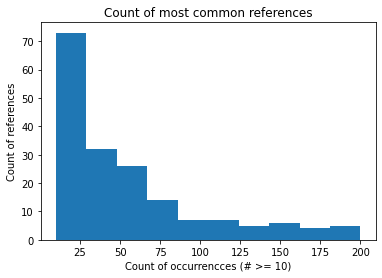

In [13]:
plt.title('Count of most common references')
plt.xlabel('Count of occurrencces (# >= 10)')
plt.ylabel('Count of references')
plt.hist([count for reference, count in counter.items()], range=[10, 200])